In [ ]:
!pip install keras==2.14.0rc0
!pip install tensorflow==2.13.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax ,Lion
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from skimage import exposure




# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
import pickle

In [ ]:
!unzip -q '/content/drive/MyDrive/AI AGENT 2.zip' -d '/content'

In [ ]:
def convert_list_to_string(list_items):
    """
    Converts a list of items into a string.

    Args:
        list_items: A list of items.

    Returns:
        A string.
    """

    string = ""
    for item in list_items:
        if isinstance(item, str):
            string += item
        elif isinstance(item, list):
            string += convert_list_to_string(item)
        else:
            string += str(item)
    return string


In [ ]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels

# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [ ]:
import cv2
import matplotlib.pyplot as plt

def adaptive_histogram_equalization_opencv(image_path, clip_limit=2.0, tile_size=(8, 8)):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Create a CLAHE object (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)

    # Apply adaptive histogram equalization
    img_eq = clahe.apply(img)

    # Display the original and enhanced images side by side
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(img_eq, cmap='gray')
    plt.title('Enhanced Image')

    plt.show()


In [ ]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size


     # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
      return img_eq

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= False)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(gen):
    '''
    This function takes the data generator and shows a sample of the images.
    '''

    # Return classes, images to be displayed
    g_dict = gen.class_indices        # Defines dictionary {'class': index}
    classes = list(g_dict.keys())     # Defines a list of dictionary keys (classes), class names: string
    images, labels = next(gen)        # Get a batch size samples from the generator

    # Calculate the number of displayed samples
    length = len(labels)        # Length of batch size
    sample = min(length, 25)    # Check if the sample is less than 25 images

    plt.figure(figsize=(20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i]

        # Check if the image is single-channel, convert to three channels
        if image.shape[-1] == 1:
            image = np.concatenate([image, image, image], axis=-1)

        image = image / 255       # Scales data to the range (0 - 1)
        plt.imshow(image)
        index = np.argmax(labels[i])  # Get image index
        class_name = classes[index]   # Get class of image
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()


In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [ ]:
import os

def count_images_per_class(dataset_path):
    class_counts = {}

    for root, dirs, files in os.walk(dataset_path):
        # Exclude hidden folders (e.g., .git) and non-class folders
        dirs[:] = [d for d in dirs if not d.startswith('.')]

        # Get the current class name from the directory
        class_name = os.path.basename(root)

        # Count the images in the current class folder
        image_count = len([f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))])

        # Update the class_counts dictionary
        class_counts[class_name] = image_count

    return class_counts

# Example usage:
dataset_path = "/content/AI AGENT 2"
class_counts = count_images_per_class(dataset_path)
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of Images: {count}")


Class: AI AGENT 2, Number of Images: 0
Class: 3, Number of Images: 1286
Class: 2, Number of Images: 2578


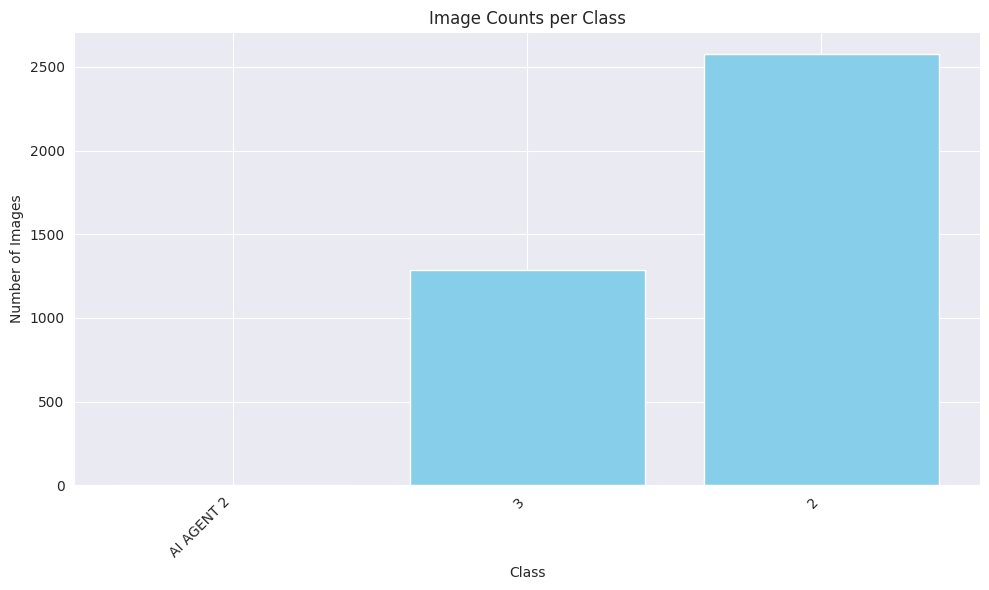

In [ ]:
import matplotlib.pyplot as plt

def plot_image_counts(class_counts):
    # Extract class names and corresponding image counts
    class_names = list(class_counts.keys())
    image_counts = list(class_counts.values())

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, image_counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Image Counts per Class')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# Assuming you already have the 'class_counts' dictionary
plot_image_counts(class_counts)


In [ ]:
data_dir = '/content/AI AGENT 2'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 16
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 3091 validated image filenames belonging to 2 classes.
Found 386 validated image filenames belonging to 2 classes.
Found 387 validated image filenames belonging to 2 classes.


In [ ]:
directory_contents = os.listdir(data_dir)

# Print the list of contents
print(directory_contents)

['3', '2']


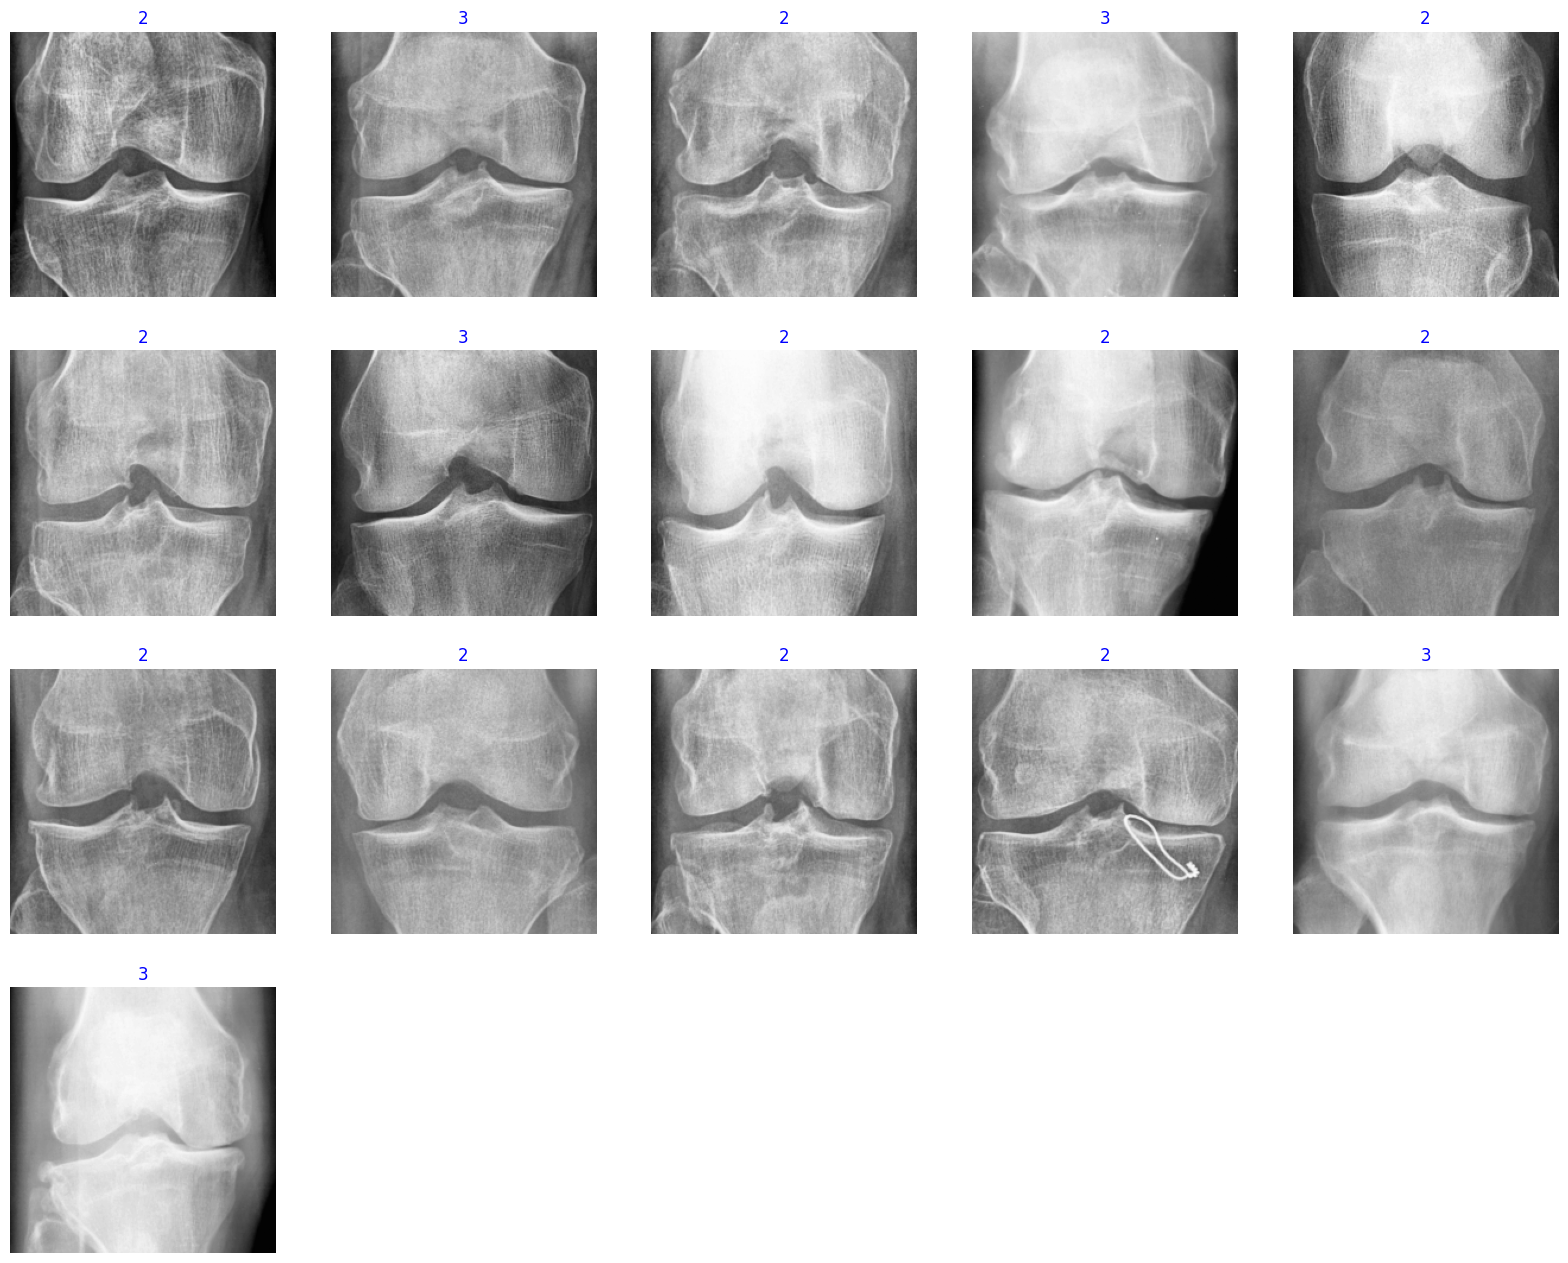

In [ ]:
show_images(train_gen)

In [ ]:

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use DenseNet201 as base model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
import tensorflow as tf

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model (DenseNet169 in this case)
base_model = tf.keras.applications.DenseNet169(include_top=True, weights="imagenet", input_shape=img_shape, pooling='max')

# Build the model
model = Sequential([
    base_model,
    Flatten(name="flatten"),
    Dense(4096, activation="relu"),
    BatchNormalization(),
    Dense(4096, activation="relu"),
    BatchNormalization(),
    Dense(4096, activation="relu"),
    BatchNormalization(),
    Dense(2048, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()




58541896/58541896 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 1000)              14307880  
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 4096)              4100096   
                                                                 
 batch_normalization (Batch  (None, 4096)              16384     
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 batch_normalization_1 (Bat  (None, 4096)              16

In [ ]:
batch_size = 32   # set batch size for training
epochs = 100   # number of all epochs in training
patience = 10   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 5   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.97   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.01   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [ ]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?
y
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /100    0.799   59.592   0.64238  66.839   0.00100  0.00100  accuracy     0.00    157.87 
 2 /100    0.688   62.181   0.63679  66.839   0.00100  0.00100  accuracy     4.34    49.24  
 3 /100    0.675   64.089   0.66605  66.839   0.00100  0.00100  accuracy     3.07    49.66  
 4 /100    0.649   64.607   0.64298  65.803   0.00100  0.00100  accuracy     0.81    49.47  
 5 /100    0.615   67.357   0.58210  61.140   0.00100  0.00100  accuracy     4.26    49.17  
enter H to halt training or an integer for number of epochs to run then ask again
20
 training will continue until epoch 25
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 6 /100    0.502   76.383   0.48772  84.456   0.00100  0.00100  accuracy    13.40    48.54  
 7 /100    0.444   79.004   0.33549  87.306   0.00100  0.00100  accuracy    

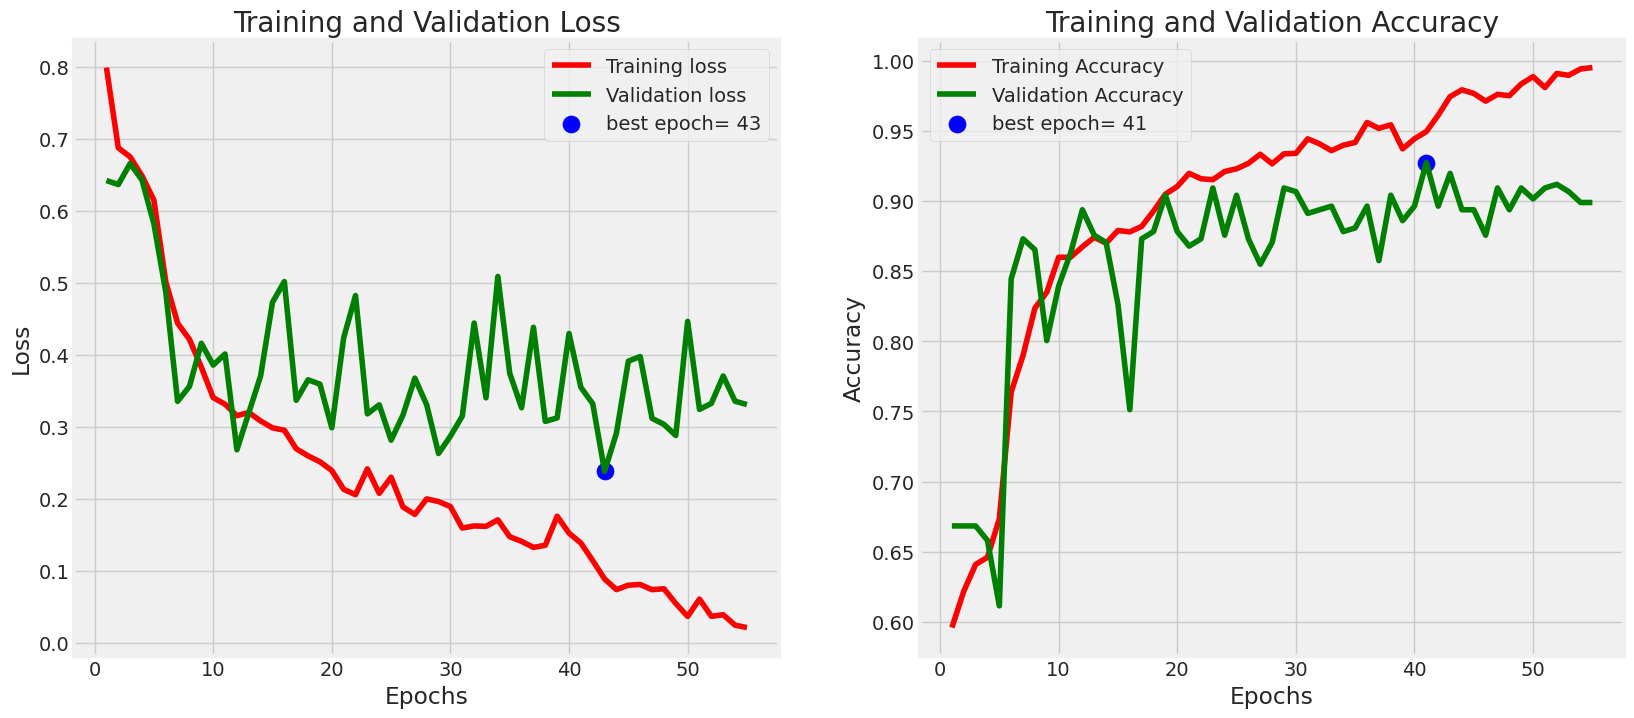

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

9/9 [==============================] - 7s 234ms/step - loss: 0.2987 - accuracy: 0.8992
Train Loss:  0.0827326625585556
Train Accuracy:  0.9861111044883728
--------------------
Validation Loss:  0.21262383460998535
Validation Accuracy:  0.9305555820465088
--------------------
Test Loss:  0.2986867427825928
Test Accuracy:  0.8992248177528381


In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 1
 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1
 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0
 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0
 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0
 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1
 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0]


Confusion Matrix, Without Normalization
[[244  14]
 [ 25 104]]
              precision    recall  f1-score   support

           2       0.91      0.95      0.93       258
           3       0.88      0.81      0.84       129

    accuracy                           0.90       387
   macro avg       0.89      0.88      0.88       387
weighted avg       0.90      0.90      0.90       387



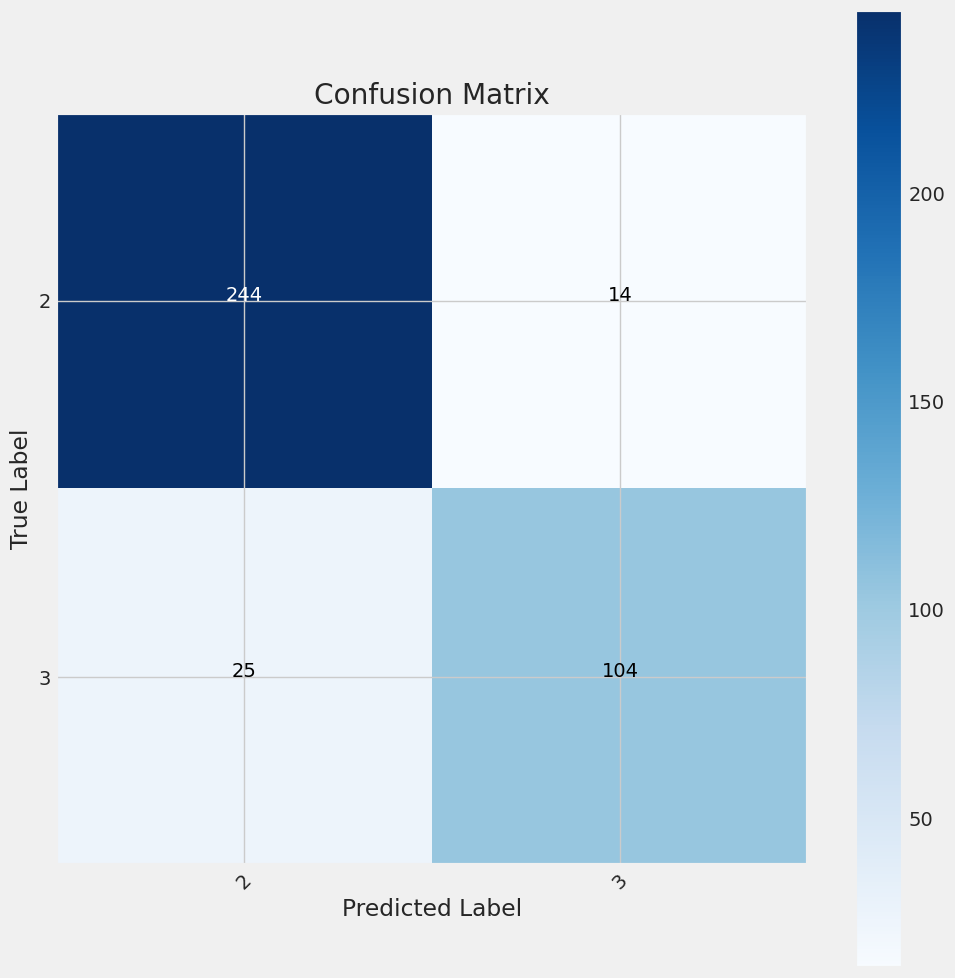

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [ ]:
model_name = model.input_names[0][:-6]
subject = 'osteo-knee-x ray'
acc = test_score[1] * 100
save_path = ''


# Save weights
#weight_save_id = str(f'{model_name}-{subject}-weights.h5')
#weights_save_loc = os.path.join(save_path, weight_save_id)
#model.save_weights(weights_save_loc)
#print(f'weights were saved as {weights_save_loc}')

In [ ]:
import pickle
pickle.dump(model, open('model_mendaley_3class.pkl', 'wb'))

##test bench


In [ ]:
def create_generator_single_image(filepath, img_size, channels, color):
    '''
    This function takes a filepath of an image and returns a generator that will yield the image as a tensor.
    '''

    img = cv2.imread(filepath)
    img = cv2.resize(img, img_size)
    img = np.expand_dims(img, axis=0)

    gen = ImageDataGenerator(preprocessing_function=None)
    gen_single = gen.flow(img, batch_size=1)
    return gen_single





In [ ]:
def get_prediction():
  from google.colab import files
  path=files.upload()
  filename = list(path.keys())[0]
  filename
  path = '/content/'+filename
  print(path)
  filepath = path
  img_size = (224, 224)
  channels = 3
  color = 'rgb'
  gen = create_generator_single_image(filepath, img_size, channels, color)
  image = next(gen)
  print(image.shape)
  prob_arr=[]
  prob_arr=model.predict(image)
  predicted_label = convert_list_to_string(np.argmax(prob_arr, axis=1))

  return predicted_label


In [ ]:
pred_xray=get_prediction()
pred_xray

KeyboardInterrupt: ignored

In [ ]:
!cp model.pkl /content/drive/MyDrive

In [ ]:
!cp densenet201-osteo-knee-x-ray-weights.h5 /content/drive/MyDrive/OA_models/densnet201